In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8960890141743625272, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15693578240
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12864928587012400759
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Loading packages")
!pip install SimpleITK
!pip install PyWavelets
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
#import cv2
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, concatenate, Activation, Add, ZeroPadding2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import SGD,Adam
#from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import SimpleITK as sitk
import numpy as np
import scipy.misc
import numpy.random as rng
import pywt
#from PIL import Image, ImageDraw, ImageFont
#from sklearn.utils import shuffle
#import nibabel as nib #reading MR images
#from sklearn.cross_validation import train_test_split
#import math
import glob
from skimage.filters.rank import entropy
from skimage.morphology import disk,rectangle
from sklearn.preprocessing import MinMaxScaler
from skimage.measure import perimeter
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from skimage.feature import canny
from skimage.feature import greycomatrix, greycoprops
print("Done")

Mounted at /content/drive
Loading packages
     |████████████████████████████████| 48.4 MB 21 kB/s 
Done


In [ ]:
!pip install tqdm

In [ ]:
tf.test.gpu_device_name()
from tqdm import tqdm

In [ ]:
start_time = time.time()
def tumor(X,label):
  #only enhancing
  if label == 4:
    X[X != 4] = 0
    X[X == 4] = 1
    #necrotic
  if label == 6:
    X[X != 1] = 0
    #only edema
  if label == 2:
    X[X != 2] = 0
    X[X == 2] = 1
  #tumor core
  if label == 1:
    X[X == 2] = 0
    X[X != 0] = 1
  #complete tumor
  if label == 5:
    X[X != 0] = 1
  #All tumor
  #if label == 3:
   # X[X == 3] = 1
  return X
end_time = time.time()
t=end_time-start_time
print(t)


0.0003132820129394531


In [ ]:
label_value=5
image_loc = "drive/My Drive/t1ce/"
image_location = image_loc
mask_location = "drive/My Drive/seg/"

In [ ]:
#_______Fiding non-zero mask index____________
    #print("Finding white slices...")
image_location = image_loc
mask_location = "drive/My Drive/seg/"
sorted_image_list = sorted(os.listdir(image_location))
sorted_mask_list = sorted(os.listdir(mask_location))
non_zero_index=[]

for i in tqdm(range(210)):
    #print("i "+str(i))
    #globber_image = glob.glob(image_location + sorted_image_list[i])
    globber_mask = glob.glob(mask_location + sorted_mask_list[i])
    #images = sisitktk.ReadImage(globber_image[0])
    masks = sitk.ReadImage(globber_mask[0])
    masks = sitk.GetArrayFromImage(masks)
    #images = sitk.GetArrayFromImage(images)
    #masks=to_categorical(masks,num_classes=5)
    masks=tumor(masks,label_value)
    #if label_num == 4:
      #masks[masks != 4] = 0
      #masks[masks == 4] = 1
    #masks=masks[:,:,:,4]
    start=-1
    #print("Calculating image "+str(i))
    for j in range(155):
      if(np.max(masks[j])==1):
          #print("found")
          #print(j)
          start=j
          break
    for j in range(155):
        if(np.max(masks[154-j])==1):
          non_zero_index.append((start,154-j))
          #print(154-j)
          break
    del masks
print("Finished.")

100%|██████████| 210/210 [00:29<00:00,  7.15it/s]

Finished.


In [ ]:
# print("Loading Training images...")
# image=[]
# mask=[]
# sorted_image_list = sorted(os.listdir(image_location))
# sorted_mask_list = sorted(os.listdir(mask_location))
# for i in range(171):
#   globber_image = glob.glob(image_location + sorted_image_list[i])
#   globber_mask = glob.glob(mask_location + sorted_mask_list[i])
#   images = sitk.ReadImage(globber_image[0])
#   masks = sitk.ReadImage(globber_mask[0])
#   masks = sitk.GetArrayFromImage(masks)
#   images = sitk.GetArrayFromImage(images)
#   masks=tumor(masks,label_value)
#   #if label_num == 4:
#          # masks[masks != 4] = 0
#           #masks[masks == 4] = 1
#   #masks=to_categorical(masks,num_classes=5)
#   masks=masks[:,24:216,24:216]
#   images=images[:,24:216,24:216]
#   for j in range(non_zero_index[i][0],non_zero_index[i][1]+1):
#     #masks=masks[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216,4].reshape(-1,192,192,1)
#     #images=images[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216].reshape(-1,192,192,1)
#     #if(np.sum(masks[j])>=400):
#     image.append(np.array(images[j]).reshape(-1,192,192))
#     mask.append(np.array(masks[j]).reshape(-1,192,192))
#   print("Image "+str(i)+" loaded.")
#   del images
#   del masks
# print("Training images loaded.")
# print("Converting NumPy Array")
# image = np.array(image).reshape(-1,192,192,1)
# mask=np.array(mask).reshape(-1,192,192,1)
# print("Done")

print("Loading Test Images...")
test_image=[]
test_mask=[]
sorted_image_list = sorted(os.listdir(image_location))
sorted_mask_list = sorted(os.listdir(mask_location))

for i in range(171,210):
  globber_image = glob.glob(image_location + sorted_image_list[i])
  globber_mask = glob.glob(mask_location + sorted_mask_list[i])
  images = sitk.ReadImage(globber_image[0])
  masks = sitk.ReadImage(globber_mask[0])
  masks = sitk.GetArrayFromImage(masks)
  images = sitk.GetArrayFromImage(images)
  masks=tumor(masks,label_value)
  #if label_num == 4:
          #masks[masks != 4] = 0
          #masks[masks == 4] = 1
  #masks=to_categorical(masks,num_classes=5)
  masks=masks[:,24:216,24:216]
  images=images[:,24:216,24:216]
  for j in range(non_zero_index[i][0],non_zero_index[i][1]+1):
    #masks=masks[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216,4].reshape(-1,192,192,1)
    #images=images[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216].reshape(-1,192,192,1)
    #if(np.sum(masks[j])>=400):
    test_image.append(np.array(images[j]).reshape(-1,192,192))
    test_mask.append(np.array(masks[j]).reshape(-1,192,192))
  print("Image "+str(i)+" loaded.")
  del images
  del masks
print("Test Images loaded")
print("Converting NumPy Array")
test_image = np.array(test_image).reshape(-1,192,192,1)
test_mask=np.array(test_mask).reshape(-1,192,192,1)
print("Done")

Loading Test Images...
Image 171 loaded.
Image 172 loaded.
Image 173 loaded.
Image 174 loaded.
Image 175 loaded.
Image 176 loaded.
Image 177 loaded.
Image 178 loaded.
Image 179 loaded.
Image 180 loaded.
Image 181 loaded.
Image 182 loaded.
Image 183 loaded.
Image 184 loaded.
Image 185 loaded.
Image 186 loaded.
Image 187 loaded.
Image 188 loaded.
Image 189 loaded.
Image 190 loaded.
Image 191 loaded.
Image 192 loaded.
Image 193 loaded.
Image 194 loaded.
Image 195 loaded.
Image 196 loaded.
Image 197 loaded.
Image 198 loaded.
Image 199 loaded.
Image 200 loaded.
Image 201 loaded.
Image 202 loaded.
Image 203 loaded.
Image 204 loaded.
Image 205 loaded.
Image 206 loaded.
Image 207 loaded.
Image 208 loaded.
Image 209 loaded.
Test Images loaded
Converting NumPy Array
Done


In [ ]:

train_image,valid_image,train_mask,valid_mask=train_test_split(image,mask,test_size=0.2,shuffle=True,random_state=1)
print("Training image shape: "+str(train_image.shape))
print("Training mask shape: "+str(train_mask.shape))
print("Validation image shape: "+str(valid_image.shape))
print("Validation mask shape: "+str(valid_mask.shape))
print("Test image shape: "+str(test_image.shape))
print("Test mask shape: "+str(test_mask.shape))
train_shape=train_image.shape[0]
valid_shape=valid_image.shape[0]
test_shape=test_image.shape[0]

NameError: ignored

In [ ]:
plt.figure(figsize=[15,15])
plt.subplot(121)
curr_img = np.reshape(image[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Image")
# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(mask[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Mask")
"""len=90
for i in range(len):
  plt.figure(figsize=[20,20])
  curr_img = np.reshape(mask[i], (192,192))
  plt.subplot(10,10,i+1)
  plt.imshow(curr_img, cmap='gray')"""


In [ ]:
def get_one_image(i,tumor_value):
  test_image=[]
  test_mask=[]
  sorted_image_list = sorted(os.listdir(image_location))
  sorted_mask_list = sorted(os.listdir(mask_location))
  globber_image = glob.glob(image_location + sorted_image_list[i])
  globber_mask = glob.glob(mask_location + sorted_mask_list[i])
  images = sitk.ReadImage(globber_image[0])
  masks = sitk.ReadImage(globber_mask[0])
  masks = sitk.GetArrayFromImage(masks)
  images = sitk.GetArrayFromImage(images)
  masks=tumor(masks,tumor_value)
  #if label_num == 4:
          #masks[masks != 4] = 0
          #masks[masks == 4] = 1
  #masks=to_categorical(masks,num_classes=5)
  masks=masks[:,24:216,24:216]
  images=images[:,24:216,24:216]
  for j in range(non_zero_index[i][0],non_zero_index[i][1]+1):
    #masks=masks[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216,4].reshape(-1,192,192,1)
    #images=images[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216].reshape(-1,192,192,1)
    #if(np.sum(masks[j])>=400):
      test_image.append(np.array(images[j]).reshape(-1,192,192))
      test_mask.append(np.array(masks[j]).reshape(-1,192,192))
  return np.array(test_image).reshape(-1,192,192,1),np.array(test_mask).reshape(-1,192,192,1)
img,msk=get_one_image(15,4)
plt.figure(figsize=[15,15])
plt.subplot(161)
curr_img = np.reshape(img[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Image")
# Display the first image in testing data
plt.subplot(162)
curr_img = np.reshape(msk[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Enchancing")
img,msk=get_one_image(0,2)
plt.subplot(163)
curr_img = np.reshape(msk[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Edema")
img,msk=get_one_image(0,1)
plt.subplot(164)
curr_img = np.reshape(msk[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Core")
img,msk=get_one_image(0,5)
plt.subplot(165)
curr_img = np.reshape(msk[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Complete")
img,msk=get_one_image(0,6)
plt.subplot(166)
curr_img = np.reshape(msk[0], (192,192))
plt.imshow(curr_img, cmap='gray')
plt.xlabel("Necrotic")

In [ ]:
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=90,
                     horizontal_flip=True,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2
                     )
seed=1
batch_size=8
train = ImageDataGenerator(**data_gen_args)
train_X = train.flow(train_image,batch_size=batch_size,seed=seed)
train_Y = train.flow(train_mask,batch_size=batch_size,seed=seed)
valid = ImageDataGenerator()
valid_X = valid.flow(valid_image,batch_size=batch_size,seed=seed)
valid_Y = valid.flow(valid_mask,batch_size=batch_size,seed=seed)
def train_gen(train_X,train_Y):
  traingen = zip(train_X,train_Y)
  for (i,j) in traingen:
    yield i,j
def valid_gen(valid_X,valid_Y):
  validgen = zip(valid_X,valid_Y)
  for (i,j) in validgen:
    yield i,j
train_generator=train_gen(train_X,train_Y)
valid_generator=valid_gen(valid_X,valid_Y)

In [ ]:
def conv_layer(input_tensor,filters,kernel_size=3):
  x = Conv2D(filters,(kernel_size,kernel_size), activation="relu", kernel_initializer='he_normal', padding='same')(input_tensor)
  x = BatchNormalization()(x)
  x = Conv2D(filters,(kernel_size,kernel_size), activation="relu", kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters,(kernel_size,kernel_size), activation="relu", kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  return x
def mixed_pool(x,a=0.5):
  max_tensor = K.pool2d(x,pool_size=(2,2),strides=(2,2),padding='valid',pool_mode='max')
  avg_tensor = K.pool2d(x,pool_size=(2,2),strides=(2,2),padding='valid',pool_mode='avg')
  #a=K.variable(value=0.5)
  final = a*max_tensor + (1-a)*avg_tensor
  return final
def mixed_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    if K.image_dim_ordering() == 'th':
        shape[2] /= 2
        shape[3] /= 2
    else:
        shape[1] /= 2
        shape[2] /= 2
    return tuple(shape)
def Light_Unet_plusplus_with_mixed_pool():
  filter_array=[32,64,128,256,512]
  inputs = Input((192,192,1))

  c00 = conv_layer(inputs,filter_array[0])
  pool0 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c00)

  c10 = conv_layer(pool0,filter_array[1])
  pool1 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c10)

  c20 = conv_layer(pool1,filter_array[2])
  pool2 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c20)

  c30 = conv_layer(pool2,filter_array[3])
  pool3 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c30)  

  c40 = conv_layer(pool3,filter_array[4])
  pool4 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c40)

  up01 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c10)
  c01 = concatenate([up01,c00])
  c01 = conv_layer(c01,filter_array[0])

  up11 = Conv2DTranspose(filter_array[1],(3,3),strides=(2,2),padding="same")(c20)
  c11 = concatenate([up11,c10])
  c11 = conv_layer(c11,filter_array[1])

  up21 = Conv2DTranspose(filter_array[2],(3,3),strides=(2,2),padding="same")(c30)
  c21 = concatenate([up21,c20])
  c21 = conv_layer(c21,filter_array[2])

  up31 = Conv2DTranspose(filter_array[3],(3,3),strides=(2,2),padding="same")(c40)
  c31 = concatenate([up31,c30])
  c31 = conv_layer(c31,filter_array[3])

  up02 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c11)
  c02 = concatenate([up02,c01,c00])
  c02 = conv_layer(c02,filter_array[0])

  up12 = Conv2DTranspose(filter_array[1],(3,3),strides=(2,2),padding="same")(c21)
  c12 = concatenate([up12,c11,c10])
  c12 = conv_layer(c12,filter_array[1])

  up22 = Conv2DTranspose(filter_array[2],(3,3),strides=(2,2),padding="same")(c31)
  c22 = concatenate([up22,c21,c20])
  c22 = conv_layer(c22,filter_array[2])

  up03 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c12)
  c03 = concatenate([up03,c02,c01,c00])
  c03 = conv_layer(c03,filter_array[0])

  up13 = Conv2DTranspose(filter_array[1],(3,3),strides=(2,2),padding="same")(c22)
  c13 = concatenate([up13,c12,c11,c10])
  c13 = conv_layer(c13,filter_array[1])

  up04 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c13)
  c04 = concatenate([up04,c03,c02,c01,c00])
  c04 = conv_layer(c04,filter_array[0])

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c04)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
def conv_layer(input_tensor,filters,kernel_size=3):
  x = Conv2D(filters,(kernel_size,kernel_size), activation="relu", kernel_initializer='he_normal', padding='same')(input_tensor)
  x = BatchNormalization()(x)
  x = Conv2D(filters,(kernel_size,kernel_size), activation="relu", kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters,(kernel_size,kernel_size), activation="relu", kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  return x
def mixed_pool(x,a=0.5):
  max_tensor = K.pool2d(x,pool_size=(2,2),strides=(2,2),padding='valid',pool_mode='max')
  avg_tensor = K.pool2d(x,pool_size=(2,2),strides=(2,2),padding='valid',pool_mode='avg')
  #a=K.variable(value=0.5)
  final = a*max_tensor + (1-a)*avg_tensor
  return final
def mixed_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    if K.image_dim_ordering() == 'th':
        shape[2] /= 2
        shape[3] /= 2
    else:
        shape[1] /= 2
        shape[2] /= 2
    return tuple(shape)
def Unet_plusplus_with_mixed_pool():
  filter_array=[32,64,128,256,512]
  inputs = Input((192,192,1))

  c00 = conv_layer(inputs,filter_array[0])
  pool0 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c00)

  c10 = conv_layer(pool0,filter_array[1])
  pool1 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c10)

  c20 = conv_layer(pool1,filter_array[2])
  pool2 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c20)

  c30 = conv_layer(pool2,filter_array[3])
  pool3 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c30)  

  c40 = conv_layer(pool3,filter_array[4])
  pool4 = Lambda(mixed_pool,mixed_pool2d_output_shape)(c40)

  up01 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c10)
  c01 = concatenate([up01,c00])
  c01 = conv_layer(c01,filter_array[0])

  up11 = Conv2DTranspose(filter_array[1],(3,3),strides=(2,2),padding="same")(c20)
  c11 = concatenate([up11,c10])
  c11 = conv_layer(c11,filter_array[1])

  up21 = Conv2DTranspose(filter_array[2],(3,3),strides=(2,2),padding="same")(c30)
  c21 = concatenate([up21,c20])
  c21 = conv_layer(c21,filter_array[2])

  up31 = Conv2DTranspose(filter_array[3],(3,3),strides=(2,2),padding="same")(c40)
  c31 = concatenate([up31,c30])
  c31 = conv_layer(c31,filter_array[3])

  up02 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c11)
  c02 = concatenate([up02,c01,c00])
  c02 = conv_layer(c02,filter_array[0])

  up12 = Conv2DTranspose(filter_array[1],(3,3),strides=(2,2),padding="same")(c21)
  c12 = concatenate([up12,c11,c10])
  c12 = conv_layer(c12,filter_array[1])

  up22 = Conv2DTranspose(filter_array[2],(3,3),strides=(2,2),padding="same")(c31)
  c22 = concatenate([up22,c21,c20])
  c22 = conv_layer(c22,filter_array[2])

  up03 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c12)
  c03 = concatenate([up03,c02,c01,c00])
  c03 = conv_layer(c03,filter_array[0])

  up13 = Conv2DTranspose(filter_array[1],(3,3),strides=(2,2),padding="same")(c22)
  c13 = concatenate([up13,c12,c11,c10])
  c13 = conv_layer(c13,filter_array[1])

  up04 = Conv2DTranspose(filter_array[0],(3,3),strides=(2,2),padding="same")(c13)
  c04 = concatenate([up04,c03,c02,c01,c00])
  c04 = conv_layer(c04,filter_array[0])

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c04)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
label=label_value
stringval=image_loc.split('/')[-2]
model_name = 'unet++_mixedpool_'
  #only enhancing
if label == 4:
  csv_logger = CSVLogger(model_name+stringval+'_enhancingtrain.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint(model_name+stringval+'_ENHANCING.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  #necrotic
if label == 6:
  csv_logger = CSVLogger(model_name+stringval+'_necrotictraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint(model_name+stringval+'_NECROTIC.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
    #only edema
if label == 2:
  csv_logger = CSVLogger(model_name+stringval+'_edematraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint(model_name+stringval+'_EDEMA.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  #tumor core
if label == 1:
  csv_logger = CSVLogger(model_name+stringval+'_coretraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint(model_name+stringval+'_CORE.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  #complete tumor
if label == 5:
  csv_logger = CSVLogger(model_name+stringval+'_completetraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint(model_name+stringval+'_COMPLETE.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  
#csv_logger = CSVLogger('training.log', separator=',', append=False)
#model.fit(X_train, Y_train, callbacks=[csv_logger])

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return 0.8*binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
import tensorflow as tf
def calculate_iou(y_true, y_pred,smooth=1):

  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def IoU(y_true, y_pred):
        
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou
def dice_score(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
from sklearn.metrics import jaccard_score
def J_score(y_true, y_pred):
    jscore=jaccard_score(y_true, y_pred, average='macro')
    return jscore
    
earlystopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True)

reducelr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    verbose=1,  
    min_delta=0.000001 )


In [ ]:
model = Unet_plusplus_with_mixed_pool()
model.compile(loss=bce_dice_loss,optimizer=Adam(learning_rate=0.0001),metrics=[dice_score,'accuracy',IoU])
model.summary()

In [ ]:
start_time = time.time()
history=model.fit_generator(train_generator,steps_per_epoch=(train_shape/batch_size),epochs=100,validation_data=valid_generator,validation_steps=(valid_shape/batch_size),callbacks=[model_checkpoint,csv_logger,reducelr])
end_time = time.time()
t=end_time-start_time
print('execution time is:')
print(t)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1152/1151 [==============================] - ETA: 0s - loss: 1.0177 - dice_score: 0.2518 - accuracy: 0.9529 - IoU: 0.1345
Epoch 00001: val_dice_score improved from -inf to 0.42859, saving model to unet++_mixedpool_t2_COMPLETE.h5
1152/1151 [==============================] - 254s 221ms/step - loss: 1.0177 - dice_score: 0.2518 - accuracy: 0.9529 - IoU: 0.1345 - val_loss: 0.6751 - val_dice_score: 0.4286 - val_accuracy: 0.9851 - val_IoU: 0.2388 - lr: 1.0000e-04
Epoch 2/100
1152/1151 [==============================] - ETA: 0s - loss: 0.4930 - dice_score: 0.5956 - accuracy: 0.9811 - IoU: 0.3542
Epoch 00002: val_dice_score improved from 0.42859 to 0.73950, saving model to unet++_mixedpool_t2_COMPLETE.h5
1152/1151 [==============================] - 251s 218ms/step - loss: 0.4930 - dice_score: 0.5956 - accuracy: 0.9811 - IoU: 0.3542 - val_loss: 0.3408 - val_dice_score: 0.7395 - val_accuracy: 0.9866 - val_IoU:

In [ ]:
import pandas as pd
df = pd.read_csv('drive/My Drive/weight/flair-complete.log', sep=',', engine='python')
df.head()

In [ ]:
model = Unet_plusplus_with_mixed_pool()
model.load_weights('drive/MyDrive/Copy of unet++_major_mixedpool_t1ce_COMPLETE.h5')

In [ ]:
pred = model.predict(test_image)


NameError: ignored

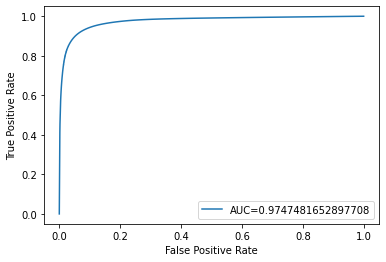

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_mask.reshape(-1), pred.reshape(-1))
auc = metrics.roc_auc_score(test_mask.reshape(-1), pred.reshape(-1))

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#plotting the graph
ax = plt.gca()
df.plot(kind='line',x='epoch',y='acc',ax=ax)
df.plot(kind='line',x='epoch',y='val_acc', color='red', ax=ax)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#import plotly.express as px
#fig = px.line(df, x = 'epoch', y = 'acc', title='Accuaracy')
#fig = px.line(df, x = 'epoch', y = 'val_acc', title='Accuaracy')
#fig.show()


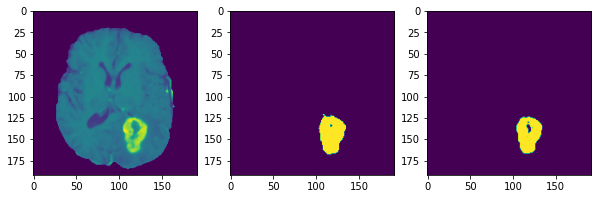

In [ ]:
model.load_weights('drive/My Drive/unet++_mixedpool_t1ce_ENHANCING.h5')
slicer=10
pred=model.predict(test_image)
plt.figure(figsize=[10,10])
plt.subplot(131)
plt.imshow(test_image[slicer].reshape(192,192))
plt.subplot(132)
plt.imshow(test_mask[slicer].reshape(192,192))
plt.subplot(133)
plt.imshow(pred[slicer].reshape(192,192))

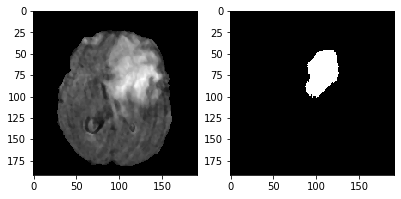

In [ ]:
plt.figure(figsize=[10,10])
#prediction_masks_test=prediction_masks.copy()
#prediction_masks_test[prediction_masks>0.5]=1
#prediction_masks_test[prediction_masks<0.5]=0
# Display the first image in training data
#plt.subplot(131)
#curr_img = np.reshape(images_test[90], (240,240))
#plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(131)
curr_img = np.reshape(train_image[111], (192,192))
plt.imshow(curr_img, cmap='gray')

plt.subplot(132)
curr_img = np.reshape(train_mask[111], (192,192))
plt.imshow(curr_img, cmap='gray')






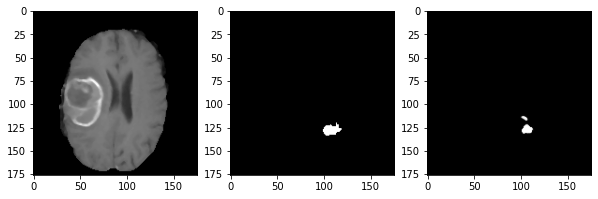

In [ ]:
plt.figure(figsize=[10,10])
plt.subplot(131)
curr_img = np.reshape(test_image[870], (192,192))
plt.imshow(curr_img, cmap='gray')

plt.subplot(132)
curr_img = np.reshape(test_mask[2], (192,192))
plt.imshow(curr_img, cmap='gray')

plt.subplot(133)
curr_img = np.reshape(prediction_masks[2], (192,192))
plt.imshow(curr_img, cmap='gray')





In [ ]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['IoU'])
print(history.history['acc'])
print(history.history['dice_score'])
print(history.history['val_loss'])
print(history.history['val_IoU'])
print(history.history['val_acc'])
print(history.history['val_dice_score'])
print(history.history['lr'])

dict_keys(['loss', 'IoU', 'acc', 'dice_score', 'val_loss', 'val_IoU', 'val_acc', 'val_dice_score', 'lr'])
[0.6810002936053946, 0.4043829455669996, 0.3853994706812285, 0.38161687516916976, 0.35366663254996983, 0.34138146235536393, 0.3348952104926966, 0.3337705792125575, 0.32641428072494594, 0.31874342401926226, 0.31530690792726584, 0.3070223795129613, 0.30932975056746054, 0.2962284493804523, 0.29645100263191315, 0.29002786354252436, 0.29311772460722596, 0.2898442677078023, 0.2893937988891701, 0.2912808713143671, 0.27908153461133006, 0.28112326259709586, 0.27304672334491625, 0.2697564173102924, 0.27086646011029875, 0.27198728385663046, 0.2674510385342317, 0.26473163492651564, 0.2612618238687671, 0.2612554659491501, 0.261299833022715, 0.264490497299147, 0.25666089998320923, 0.2592674058531718, 0.2540531320501043, 0.25583140105301067, 0.2501492089963598, 0.24995327110698534, 0.2535868003078725, 0.25057568163127386, 0.24913174801601606, 0.24687270387997431, 0.24664236197356382, 0.2401785224

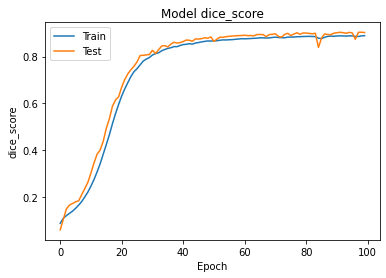

In [ ]:
plt.plot(history.history['dice_score'])
plt.plot(history.history['val_dice_score'])
plt.title('Model dice_score')
plt.ylabel('dice_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#print(history.history.keys())
#history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
print(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig('drive/My Drive/Model loss.png')

plt.plot(history.history['dice_score'])
plt.plot(history.history['val_dice_score'])
plt.title('Model dice_score')
plt.ylabel('dice_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['IoU'])
plt.plot(history.history['val_IoU'])
plt.title('Model IoU')
plt.ylabel('dice_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

KeyError: ignored

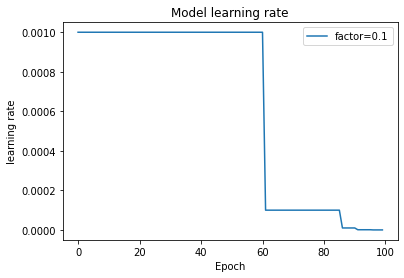

In [ ]:
plt.plot(history.history['lr'])
#plt.plot(history.history['val_lr'])
plt.title('Model learning rate')
plt.ylabel('learning rate')
plt.xlabel('Epoch')
plt.legend(['factor=0.1'], loc='upper right')
plt.show()


In [ ]:
model1= Unet_plusplus_with_mixed_pool()
model1.load_weights('drive/My Drive/unet++_mixedpool_t1ce_ENHANCING.h5')
prediction_masks = model1.predict(test_image)
#prediction_masks[prediction_masks>0.5]=1
#prediction_masks[pred"iction_masks<0.5]=0
#prediction_masks.shape
prediction_masks.shape

(1863, 192, 192, 1)

In [ ]:
prediction_masks_test=prediction_masks.copy()
prediction_masks_test[prediction_masks_test>0.5]=1
prediction_masks_test[prediction_masks_test<0.5]=0

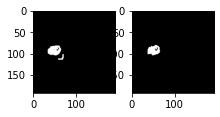

In [ ]:

plt.figure(figsize=[5,5])
prediction_masks_test=prediction_masks.copy()
prediction_masks_test[prediction_masks>0.5]=1
prediction_masks_test[prediction_masks<0.5]=0
# Display the first image in training data
#plt.subplot(131)
#curr_img = np.reshape(images_test[90], (240,240))
#plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(132)
curr_img = np.reshape(test_mask[100], (192,192))
plt.imshow(curr_img, cmap='gray')

plt.subplot(133)
curr_img = np.reshape(prediction_masks_test[100], (192,192))
plt.imshow(curr_img, cmap='gray')



In [ ]:
from sklearn.metrics import mean_squared_error , f1_score
mse=mean_squared_error(test_mask.reshape(-1),prediction_masks_test.reshape(-1))
print(mse)
from sklearn.metrics import confusion_matrix
#results = confusion_matrix(test_mask.reshape(-1),prediction_masks_test.reshape(-1))
results=f1_score(test_mask.reshape(-1),prediction_masks_test.reshape(-1),average='macro')
print(results)

0.0051623504
0.9232003452793278


In [ ]:
sensitivity1 = results[0,0]/(results[0,0]+results[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = results[1,1]/(results[1,0]+results[1,1])
print('Specificity : ', specificity1)

accuracy = (results[1,1]+results[0,0])/(results[1,1]+results[1,0]+results[0,1]+results[0,0])
print("Accuracy: ",accuracy)

Sensitivity :  0.9962678357619908
Specificity :  0.8360942272218694
Accuracy:  0.9886075869080297


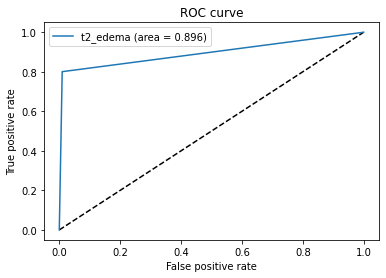

In [ ]:
#Plotting ROC curve
from sklearn.metrics import roc_curve,roc_auc_score
y_pred = model.predict(test_image).ravel()
y_pred [y_pred >0.5]=1
y_pred [y_pred <0.5]=0
#y_prob=.model.predict_proba(test_image)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_mask.reshape(-1), y_pred.reshape(-1))
#fpr , tpr , thresholds = roc_curve ( test_mask , y_val_cat_prob)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='t2_edema (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(prediction_masks_test.reshape(-1),test_mask.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99  73837794
         1.0       0.80      0.84      0.82   4350750

    accuracy                           0.98  78188544
   macro avg       0.90      0.91      0.90  78188544
weighted avg       0.98      0.98      0.98  78188544



In [ ]:
from sklearn.metrics import f1_score
score = f1_score(test_mask.reshape(-1), prediction_masks_test.reshape(-1),average='macro')
# print
print(score)

0.93466944912473


In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(test_mask.reshape(-1), prediction_masks_test.reshape(-1),pos_label=1, average='binary')
